In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.cvat import read_spatial_priors_from_cvat
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    collect_run_metadata,
    plot_spatial_priors,
    plot_velocity_magnitude,
    postprocess_mcmc_results,
    sample_model,
    save_run_metadata,
)
from ppcluster.preprocessing import (
    apply_2d_gaussian_filter,
    apply_dic_filters,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector
from ppcx_models import (
    build_marginalized_mixture_model,
)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [2]:
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 2000  # Number of MCMC draws
TUNE = 1000  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-06-22"
reference_end_date = "2024-06-22"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours
# dt_min = 24  # 72  # Minimum time difference between images in hours
# dt_max = 200  # 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'


# Parse various parameters from config file (or set manually here)
variables_names = ["V", "x", "y"]
roi_path = config.get("data.roi_path")
filter_kwargs = dict(
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
    min_velocity=config.get("dic.min_velocity"),
    # apply_2d_median=config.get("dic.apply_2d_median"),
    # median_window_size=config.get("dic.median_window_size"),
    # median_threshold_factor=config.get("dic.median_threshold_factor"),
    # apply_2d_gaussian=config.get("dic.apply_2d_gaussian", True),
    # gaussian_sigma=config.get("dic.gaussian_sigma", 1.0),
)

# == PRIORS ==
# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }
SECTOR_PRIOR_FILE = Path("data/priors_3_sectors.xml")
PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Output paths
output_dir = Path("output") / f"{camera_name}_PyMC"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = (
    f"PPCX_mcmc_{camera_name}_{reference_start_date}_{reference_end_date}_multiscale"
)

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)
print(dic_analyses)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)

2025-09-23 14:33:54 | [INFO    ] Found 1 DIC analyses matching criteria


   dic_id camera_name          master_timestamp           slave_timestamp  \
0    1805   PPCX_Tele 2024-06-19 06:00:19+00:00 2024-06-22 06:00:18+00:00   

   master_image_id  slave_image_id  dt_hours  
0            34195           34223        72  


In [4]:
# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

# Apply ROI filter
selector = PolygonROISelector.from_file(roi_path)
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 1:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# Read spatial priors
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)

2025-09-23 14:33:55 | [INFO    ] Fetched DIC data for id 1805 with 3927 points
2025-09-23 14:33:55 | [INFO    ] Found stack of 1 DIC dataframes. Run filtering...
2025-09-23 14:33:55 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-23 14:33:55 | [INFO    ] Percentile filtering: 3927 -> 3848 points (removed 79 outliers)
2025-09-23 14:33:55 | [INFO    ] Min velocity filtering: 3848 -> 3093 points (removed 755 points below 1)
2025-09-23 14:33:55 | [INFO    ] DIC filtering pipeline completed: 3927 -> 3093 points (removed 834 total)
2025-09-23 14:33:55 | [INFO    ] Data shape after filtering and stacking: (3093, 5)
2025-09-23 14:33:55 | [INFO    ] Filtered 3093 points to 2690 points inside polygon


## RUN MCMC with single scale model


In [ ]:
base_name = f"PPCX_mcmc_{camera_name}_{reference_start_date}_{reference_end_date}"

# Run for unsmoothed data
df_run = df.copy()

# Assign spatial priors
prior_probs = assign_spatial_priors(
    df_run["x"].to_numpy(),
    df_run["y"].to_numpy(),
    sectors,
    prior_probs=PRIOR_PROBABILITY,
)
fig, axes = plot_spatial_priors(df_run, prior_probs, img=img)
fig.savefig(
    output_dir / f"{base_name}_spatial_priors.jpg",
    dpi=150,
    bbox_inches="tight",
)

# Plot velocity field
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_velocity_magnitude(
    df_run["x"].to_numpy(),
    df_run["y"].to_numpy(),
    df_run["V"].to_numpy(),
    img=img,
    ax=ax,
)
fig.savefig(
    output_dir / f"{base_name}_velocity_field.jpg",
    dpi=150,
    bbox_inches="tight",
)

In [ ]:
# Fit scaler on data
# variables_names = ["V"]
scaler = RobustScaler()
scaler.fit(df_run[variables_names].values)
joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
logger.info(
    f"Using features: {variables_names} with shape {df_run[variables_names].shape}"
)

# Scale data for model input
data_array_scaled = scaler.transform(df_run[variables_names].to_numpy())

# Build model
model = build_marginalized_mixture_model(data_array_scaled, prior_probs, sectors)

# Sample model
sample_args = dict(
    target_accept=TARGET_ACCEPT,
    draws=3000,
    tune=1000,
    chains=CHAINS,
    cores=CORES,
    random_seed=RANDOM_SEED,
)
idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)

idata_summary = az.summary(idata, var_names=["mu", "sigma"])
print(idata_summary)

metadata = collect_run_metadata(
    idata=idata,
    convergence_flag=convergence_flag,
    data_array_scaled=data_array_scaled,
    variables_names=variables_names,
    sectors=sectors,
    prior_probs=prior_probs,
    sample_args=sample_args,
    frame=locals(),  # Pass current local variables
)

save_run_metadata(output_dir, base_name, metadata)

In [ ]:
# Postprocess results
posterior_probs, cluster_pred, uncertainty = postprocess_mcmc_results(
    idata,
    df_run,
    scaler,
    img,
    output_dir,
    base_name,
)

## RUN MCMC with multiscale model


2025-09-23 14:34:02 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=1
2025-09-23 14:34:02 | [INFO    ] Estimated grid spacing: 64.00
2025-09-23 14:34:03 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-23 14:34:03 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
2025-09-23 14:34:03 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=2
2025-09-23 14:34:03 | [INFO    ] Estimated grid spacing: 64.00
2025-09-23 14:34:03 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-23 14:34:03 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
2025-09-23 14:34:03 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=3
2025-09-23 14:34:03 | [INFO    ] Estimated grid spacing: 64.00
2025-09-23 14:34:03 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-23 14:34:03 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped

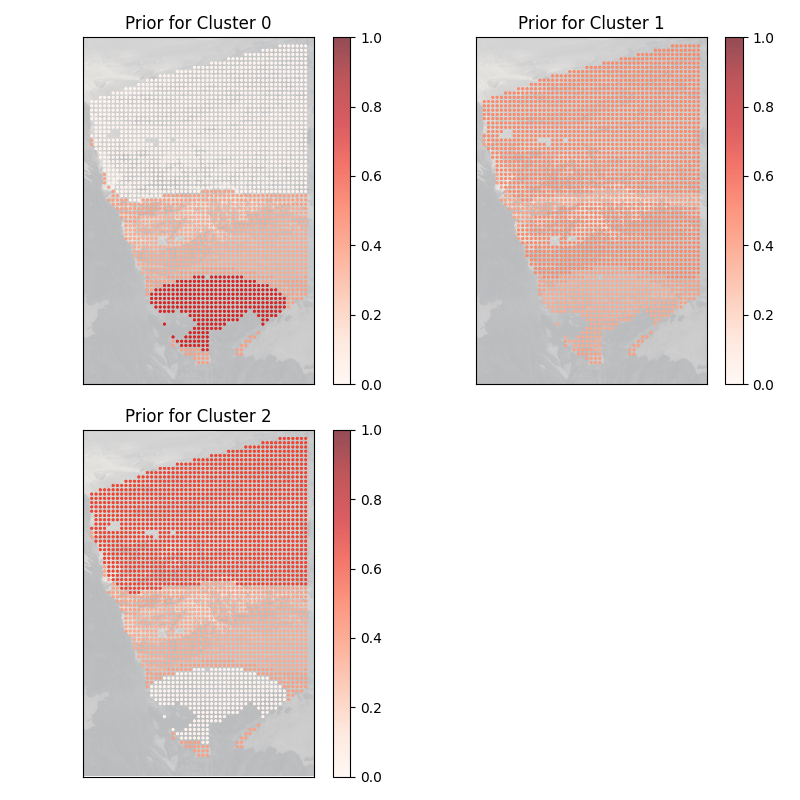

In [5]:
base_name = (
    f"PPCX_mcmc_{camera_name}_{reference_start_date}_{reference_end_date}_multiscale"
)

# Smooth the velocity field with a Gaussian filter with different scales and stack the features together in a single dataframe to run a multiscale analysis
sigma_values = [1, 2, 3]  # Different Gaussian smoothing scales
df_run = df.copy()
for sigma in sigma_values:
    smoothed = apply_2d_gaussian_filter(df, sigma=sigma)
    df_run = pd.concat([df_run, smoothed])

# Assign spatial priors
prior_probs = assign_spatial_priors(
    df_run["x"].to_numpy(),
    df_run["y"].to_numpy(),
    sectors,
    prior_probs=PRIOR_PROBABILITY,
)
plot_spatial_priors(df_run, prior_probs, img=img);

In [11]:
df_run["log_y"] = np.log(df_run["y"] + 1e-6)

# Fit scaler on data
variables_names = ["V", "log_y"]
scaler = RobustScaler()
scaler.fit(df_run[variables_names].values)
joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
logger.info(
    f"Using features: {variables_names} with shape {df_run[variables_names].shape}"
)

# Scale data for model input
data_array_scaled = scaler.transform(df_run[variables_names].to_numpy())

# Build model
model = build_marginalized_mixture_model(data_array_scaled, prior_probs, sectors)

2025-09-23 15:00:30 | [INFO    ] Using features: ['V', 'log_y'] with shape (10760, 2)


2025-09-23 15:00:30 | [INFO    ] Marginalized mixture model (un-sampled) created.


In [ ]:
# Sample model
sample_args = dict(
    target_accept=0.9,
    draws=2000,
    tune=1000,
    chains=CHAINS,
    cores=CORES,
    random_seed=RANDOM_SEED,
)
idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)

idata_summary = az.summary(idata, var_names=["mu", "sigma"])
print(idata_summary)

metadata = collect_run_metadata(
    idata=idata,
    convergence_flag=convergence_flag,
    data_array_scaled=data_array_scaled,
    variables_names=variables_names,
    sectors=sectors,
    prior_probs=prior_probs,
    sample_args=sample_args,
    frame=locals(),  # Pass current local variables
)

save_run_metadata(output_dir, base_name, metadata)

2025-09-23 15:00:35 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 167 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
2025-09-23 15:03:24 | [INFO    ] Sampling completed.
2025-09-23 15:03:24 | [WARNING ] MCMC chains did not fully converge by r_hat/ess criteria.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     0.516  0.017   0.496    0.549      0.008    0.004       7.0   
mu[0, 1]     0.472  0.006   0.460    0.481      0.002    0.001       7.0   
mu[1, 0]    -0.185  0.350  -0.798    0.025      0.175    0.101       7.0   
mu[1, 1]    -0.197  0.306  -0.740   -0.011      0.153    0.088       7.0   
mu[2, 0]    -0.421  0.229  -0.564   -0.018      0.114    0.066       7.0   
mu[2, 1]    -0.602  0.199  -0.735   -0.249      0.099    0.057       7.0   
sigma[0, 0]  0.301  0.026   0.252    0.323      0.013    0.007       7.0   
sigma[0, 1]  0.178  0.003   0.174    0.183      0.001    0.000      16.0   
sigma[1, 0]  0.169  0.042   0.139    0.245      0.021    0.012       7.0   
sigma[1, 1]  0.318  0.285   0.146    0.820      0.142    0.082       7.0   
sigma[2, 0]  0.372  0.092   0.209    0.432      0.046    0.026       7.0   
sigma[2, 1]  0.649  0.103   0.464    0.721      0.051    0.029       7.0   

           

2025-09-23 15:03:55 | [INFO    ] Postprocessing outputs saved to output/PPCX_Tele_PyMC


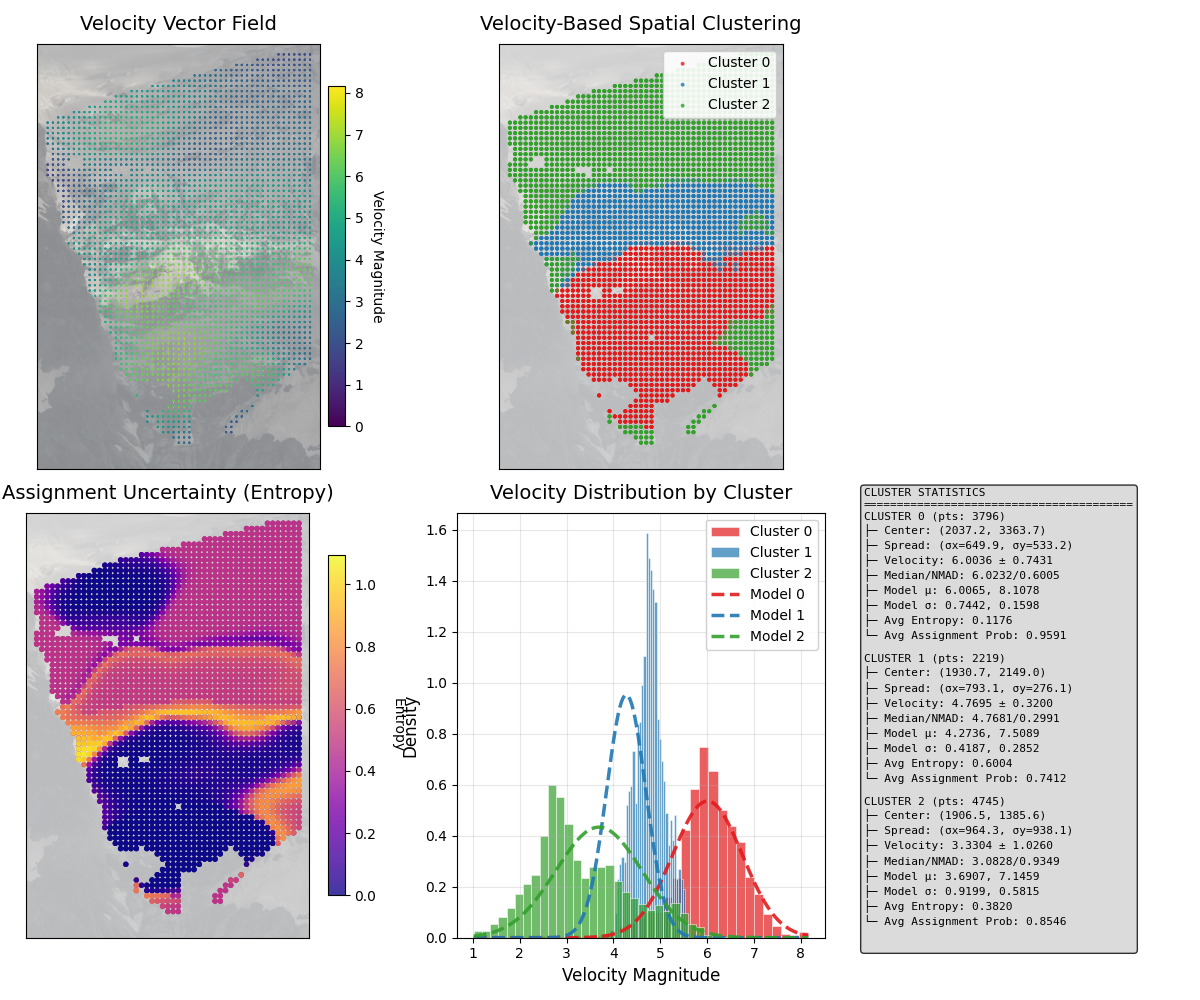

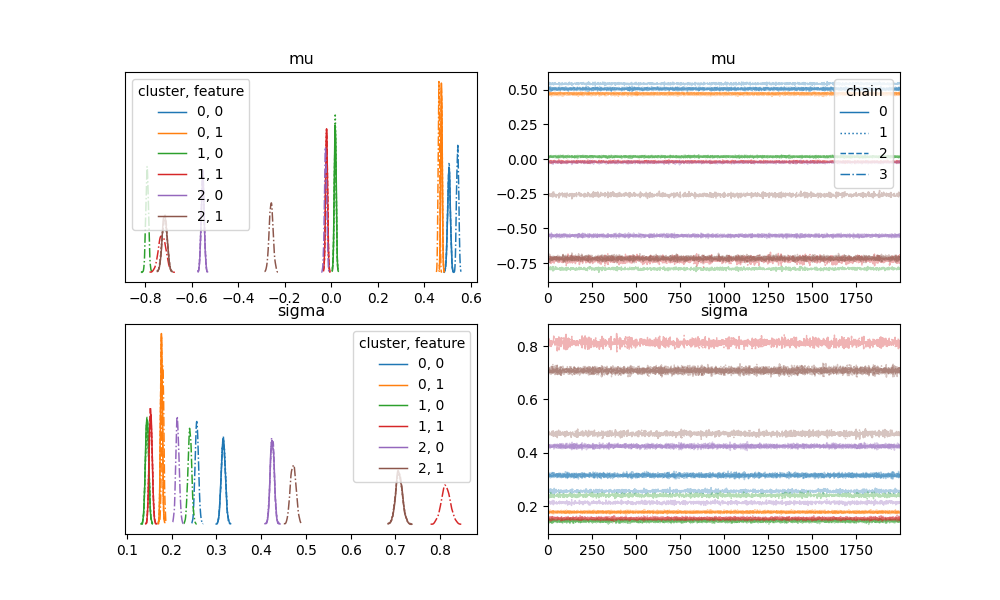

In [13]:
# Postprocess results
posterior_probs, cluster_pred, uncertainty = postprocess_mcmc_results(
    idata,
    df_run,
    scaler,
    img,
    output_dir,
    base_name,
)